In [29]:
!pip install cyton

ERROR: Could not find a version that satisfies the requirement cyton (from versions: none)
ERROR: No matching distribution found for cyton


In [52]:
# https://amspector100.github.io/knockpy/usage.html
import knockpy as kpy
from knockpy.knockoff_filter import KnockoffFilter
from data import load_IHDP_data
from knockpy import utilities
import knockpy
import numpy as np
from numpy import exp
from scipy.stats import boxcox
data_train, data_test = load_IHDP_data(type_a=True, i=0)
# Generate synthetic data from a Gaussian linear model

X = data_test['x']
y = data_test['y']
Sigma, _ = utilities.estimate_covariance(
                    X, tol=1e-6, shrinkage=None
                )

# Run model-X knockoffs
kfilter = KnockoffFilter(
    fstat='lasso',
    ksampler='gaussian',
)
rejections = kfilter.forward(X=X, y=y,  fdr=0.1, shrinkage="ledoitwolf")
beta = knockpy.dgp.create_sparse_coefficients(p=25, sparsity=0.1)
power = np.dot(rejections, beta != 0) / (beta != 0).sum()
fdp = np.around(100*np.dot(rejections, beta == 0) / rejections.sum(), 2)
print(f"The knockoff filter has discovered {100*power}% of the non-nulls with a FDP of {fdp}%")
rejections

The knockoff filter has discovered 0.0% of the non-nulls with a FDP of nan%


/tmp/ipykernel_4394/2864286289.py:26: RuntimeWarning: invalid value encountered in double_scalars
  fdp = np.around(100*np.dot(rejections, beta == 0) / rejections.sum(), 2)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [44]:

kfilter2 = KnockoffFilter(ksampler='gaussian', fstat='lasso')
rejections = kfilter.forward(X=X, y=y, fdr=0.1, shrinkage="ledoitwolf")
# Check the number of discoveries we made
# Create random sparse coefficients
beta = knockpy.dgp.create_sparse_coefficients(p=25, sparsity=0.1)
power = np.dot(rejections, beta != 0) / (beta != 0).sum()
fdp = np.around(100*np.dot(rejections, beta == 0) / rejections.sum(), 2)
print(f"The knockoff filter has discovered {100*power}% of the non-nulls with a FDP of {fdp}%")

The knockoff filter has discovered 0.0% of the non-nulls with a FDP of nan%


/tmp/ipykernel_4394/2052623170.py:9: RuntimeWarning: invalid value encountered in double_scalars
  fdp = np.around(100*np.dot(rejections, beta == 0) / rejections.sum(), 2)


In [1]:
import numpy as np
from DeepKnockoffs import KnockoffMachine
from DeepKnockoffs import GaussianKnockoffs
import data
import parameters
import selection
from data import load_IHDP_data

In [2]:
data_train, data_test = load_IHDP_data(type_a=True, i=0)

## Second-order knockoffs

In [3]:
# Compute the empirical covariance matrix of the training data
SigmaHat = np.cov(data_train['x'], rowvar=False)

# Initialize generator of second-order knockoffs
second_order = GaussianKnockoffs(SigmaHat, mu=np.mean(data_train['x'],0), method="sdp")

# Measure pairwise second-order knockoff correlations
corr_g = (np.diag(SigmaHat) - np.diag(second_order.Ds)) / np.diag(SigmaHat)

print('Average absolute pairwise correlation: %.3f.' %(np.mean(np.abs(corr_g))))

Average absolute pairwise correlation: 0.459.


## Deep knockoff machine

The default parameters of the machine are set below, as most appropriate for the specific built-in model considered.
The figures in the paper were obtained by setting the number of epochs to 1000 and the learning rate to 0.001, while in order to reduce the runtime this notebook uses the values 100 and 0.01 respectively.

In [4]:
# Load the built-in multivariate Student's-t model and its default parameters
# The currently available built-in models are:
# - gaussian : Multivariate Gaussian distribution
# - gmm      : Gaussian mixture model
# - mstudent : Multivariate Student's-t distribution
# - sparse   : Multivariate sparse Gaussian distribution
model = "gmm"
# Number of features
n = data_train['x'].shape[0]
p = data_train['x'].shape[1]

In [5]:
# Load the default hyperparameters for this model
training_params = parameters.GetTrainingHyperParams(model)

# Set the parameters for training deep knockoffs
pars = dict()
# Number of epochs
pars['epochs'] = 100
# Number of iterations over the full data per epoch
pars['epoch_length'] = 100
# Data type, either "continuous" or "binary"
pars['family'] = "continuous"
# Dimensions of the data
pars['p'] = p
# Size of the test set
pars['test_size']  = 0
# Batch size
pars['batch_size'] = int(0.5*n)
# Learning rate
pars['lr'] = 0.01
# When to decrease learning rate (unused when equal to number of epochs)
pars['lr_milestones'] = [pars['epochs']]
# Width of the network (number of layers is fixed to 6)
pars['dim_h'] = int(10*p)
# Penalty for the MMD distance
pars['GAMMA'] = training_params['GAMMA']
# Penalty encouraging second-order knockoffs
pars['LAMBDA'] = training_params['LAMBDA']
# Decorrelation penalty hyperparameter
pars['DELTA'] = training_params['DELTA']
# Target pairwise correlations between variables and knockoffs
pars['target_corr'] = corr_g
# Kernel widths for the MMD measure (uniform weights)
pars['alphas'] = [1.,2.,4.,8.,16.,32.,64.,128.]

In [6]:
# Where to store the machine
checkpoint_name = "tmp/" + model

# Where to print progress information
logs_name = "tmp/" + model + "_progress.txt"

In [7]:
# Initialize the machine
machine = KnockoffMachine(pars, checkpoint_name=checkpoint_name, logs_name=logs_name)

In [8]:
# Train the machine
import torch
torch.backends.cudnn.benchmark = True
print("Fitting the knockoff machine...")
machine.train(data_train['x'])

Fitting the knockoff machine...
[   1/ 100], Loss: 0.6612, MMD: 0.4011, Cov: 0.413, Decorr: 0.458
[   2/ 100], Loss: 0.4270, MMD: 0.3697, Cov: 0.379, Decorr: 0.464
[   3/ 100], Loss: 0.4225, MMD: 0.3703, Cov: 0.386, Decorr: 0.450
[   4/ 100], Loss: 0.4164, MMD: 0.3664, Cov: 0.382, Decorr: 0.452
[   5/ 100], Loss: 0.4156, MMD: 0.3680, Cov: 0.364, Decorr: 0.458
[   6/ 100], Loss: 0.4089, MMD: 0.3656, Cov: 0.372, Decorr: 0.453
[   7/ 100], Loss: 0.4085, MMD: 0.3657, Cov: 0.363, Decorr: 0.458
[   8/ 100], Loss: 0.4096, MMD: 0.3669, Cov: 0.380, Decorr: 0.455
[   9/ 100], Loss: 0.4091, MMD: 0.3659, Cov: 0.388, Decorr: 0.466
[  10/ 100], Loss: 0.4078, MMD: 0.3662, Cov: 0.379, Decorr: 0.451
[  11/ 100], Loss: 0.4027, MMD: 0.3633, Cov: 0.397, Decorr: 0.455
[  12/ 100], Loss: 0.4078, MMD: 0.3670, Cov: 0.391, Decorr: 0.447
[  13/ 100], Loss: 0.4016, MMD: 0.3634, Cov: 0.379, Decorr: 0.456
[  14/ 100], Loss: 0.4017, MMD: 0.3634, Cov: 0.405, Decorr: 0.461
[  15/ 100], Loss: 0.4046, MMD: 0.3658, Cov:

In [9]:
Xk_m = machine.generate(data_train['x'])

In [10]:
# Generate deep knockoffs
Xk_train_m = machine.generate(data_train['x'])
print("Size of the deep knockoff dataset: %d x %d." %(Xk_train_m.shape))

# Generate second-order knockoffs
Xk_train_g = second_order.generate(data_train['x'])
print("Size of the second-order knockoff dataset: %d x %d." %(Xk_train_g.shape))

Size of the deep knockoff dataset: 673 x 25.
Size of the second-order knockoff dataset: 673 x 25.


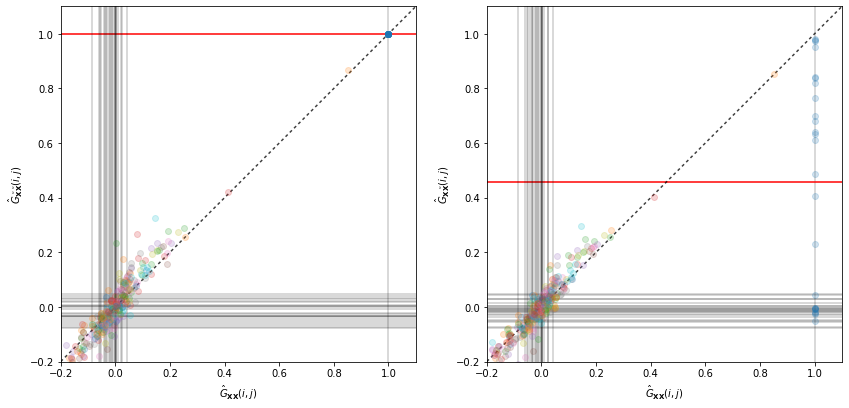

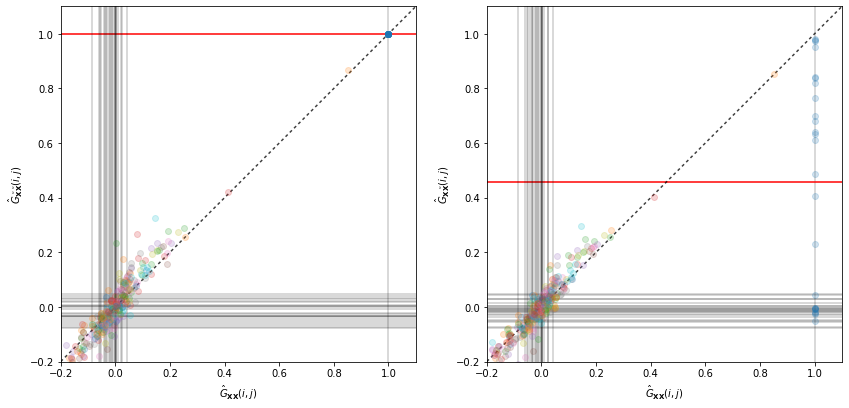

In [11]:
# Plot diagnostics for deep knockoffs
import diagnostics
diagnostics.ScatterCovariance(data_train['x'], Xk_train_m)

In [12]:
# Number of non-zero coefficients in P(Y|X)
signal_n = 25

# Amplitude of the non-zero coefficients
signal_amplitude_vec = [3, 5, 7, 10, 15, 20, 25]

# Compute the FDR as the average proportion of false discoveries over n_experiments
n_experiments = 100

# Target FDR level
nominal_fdr = 0.1

In [13]:
test_params = parameters.GetFDRTestParams(model)

In [27]:
from IPython import get_ipython
# Initialize table of results
import pandas as pd
results = pd.DataFrame(columns=['Model','Experiment', 'Method', 'FDP', 'Power', \
                                'Amplitude', 'Signals', 'Alpha', 'FDR.nominal'])

# Run experiments
# for amp_id in range(len(signal_amplitude_vec)):
#     # Set the signal amplitude
signal_amplitude = signal_amplitude_vec[0]
print("Running %d experiments with signal amplitude: %.2f" %(n_experiments,signal_amplitude))

for exp_id in range(1):

    # Sample X
    X = data_train['x']

    # Sample Y|X
    y = data_train['y']

    # Generate deep knockoffs
    Xk_m = machine.generate(X)
    # Compute importance statistics
    W_m  = selection.lasso_stats(X,Xk_m,y,alpha=test_params["elasticnet_alpha"],scale=False)
    # Select important variables with the knockoff filter
    selected_m, FDP_m, POW_m = selection.select_v(W_m,  nominal_fdr=nominal_fdr)
    # Store results
    results = results.append({'Model':model,'Experiment':exp_id, 'Method':'deep',
                              'Power':POW_m, 'FDP':FDP_m, \
                              'Amplitude':signal_amplitude, 'Signals':signal_n, \
                              'Alpha':0.1, 'FDR.nominal':nominal_fdr}, ignore_index=True)

    # # Generate second-order knockoffs
    # Xk_g = second_order.generate(X)
    # # Compute importance statistics
    # W_g  = selection.lasso_stats(X,Xk_g,y,alpha=test_params["elasticnet_alpha"],scale=False)
    # # Select important variables with the knockoff filter
    # selected_g, FDP_g, POW_g = selection.select(W_g, theta, nominal_fdr=nominal_fdr)
    # # Store results
    # results = results.append({'Model':model,'Experiment':exp_id, 'Method':'second-order',
    #                           'Power':POW_g, 'FDP':FDP_g, \
    #                           'Amplitude':signal_amplitude, 'Signals':signal_n, \
    #                           'Alpha':0.1, 'FDR.nominal':nominal_fdr}, ignore_index=True)
    #
    # sys.stdout.write('\n')

Running 100 experiments with signal amplitude: 3.00


Error evaluating: thread_id: pid_4394_id_139650016073568
frame_id: 94234627652400
scope: FRAME
attrs: foldid
Traceback (most recent call last):
  File "/snap/pycharm-professional/265/plugins/python/helpers/pydev/_pydevd_bundle/pydevd_vars.py", line 286, in resolve_compound_variable_fields
    return _typeName, resolver.get_dictionary(VariableWithOffset(var, offset) if offset else var)
  File "/snap/pycharm-professional/265/plugins/python/helpers/pydev/pydevd_plugins/extensions/types/pydevd_plugin_numpy_types.py", line 93, in get_dictionary
    ret['min'] = obj.min()
  File "/home/andrei/anaconda3/envs/deepknock/lib/python3.9/site-packages/numpy/core/_methods.py", line 44, in _amin
    return umr_minimum(a, axis, None, out, keepdims, initial, where)
ValueError: zero-size array to reduction operation minimum which has no identity


KeyboardInterrupt: 